In [76]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
# Import statements required for Plotly 
import plotly.offline as py
py.init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings('ignore')

In [77]:
import os
data_folder = '/home/shuvayan/Downloads/Deloitte/'
attrition = pd.read_csv(data_folder + 'Attrition.csv')
attrition.head()

,Terminated,Rehire,Employee_code,Department,Job Level,Tenure,TimeLastPos,Has been promoted,LastRating,Client work travel,Education,Gender,Marital Status,Annual Income,Year of Birth
0,1,False,140384,Risk Management,Senior Analyst,253,253,No,1.965571,High Travel,Bachelors Degree,F,Single,1678,1963
1,1,False,120921,Tax,Senior Analyst,1384,118,Yes,1.000000,Medium Travel,Bachelors Degree,M,Married,2144,1966
2,1,False,88512,Audit,Staff I,1188,482,Yes,2.000000,Medium Travel,Msc Analytics,M,Married,584,1977
3,1,False,80636,Financial Advisory,Lead Analyst,1013,1013,No,2.000000,Medium Travel,MA,F,Married,6205,1970
4,0,False,123543,Sales,Lead Analyst,1300,1132,Yes,2.000000,Medium Travel,MA,F,Married,6986,1970


In [78]:
#Drop the employee code:
attrition.drop('Employee_code', axis=1, inplace=True)
#Calculate age from DOB column : Assumption - Employees have left in 2017
attrition.drop('Year of Birth',axis = 1,inplace = True)
attrition.isnull().any()

Terminated            False
Rehire                False
Department             True
Job Level             False
Tenure                False
TimeLastPos           False
Has been promoted     False
LastRating            False
Client work travel    False
Education             False
Gender                False
Marital Status        False
Annual Income         False
dtype: bool

In [79]:
#Only department has missing values,assign a seperate category to these records
attrition_df = attrition.fillna("unknown")
attrition_df.isnull().any()
attrition_df.columns.to_series().groupby(attrition_df.dtypes).groups
# The target column is in integer format,change to categorical
attrition_df['Terminated'] = attrition_df['Terminated'].astype('category')
# Summary statistics of the data:
attrition_df.describe()
attrition_df.shape

(11790, 13)

In [80]:
#There seem to be some spurious data which have tenure as -ve ,check if such records are less than 5% of the sample,if so delete.
attrition_df.Tenure.le(0).value_counts(True)
#This is a very small % hence remove these records
attrition_df.drop(attrition_df[attrition_df.Tenure < 0].index, inplace=True)

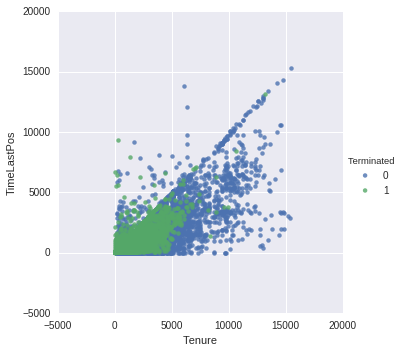

In [81]:
#Let's see the distribution of Terminated vis a vis Tenure and TimeLastPos
sns.lmplot('Tenure', 'TimeLastPos', data=attrition_df, hue='Terminated', fit_reg=False)
plt.show()

There is a huge concentration of Terminated = 1 around the region where both Tenure and TimeLastPos are low.It also seems that there are records where Tenure < TimeLastPos.Also there are records where TimeLastPos = 0 & also Hasbeenpromoted = 'Yes',which is clearly erroneous.So let us inspect these records.

In [82]:
attrition_err = attrition_df.loc[(attrition_df['TimeLastPos'] > attrition_df['Tenure']) | (attrition_df['TimeLastPos'] == 0)]
attrition_err.head()
attrition_err.shape

(1278, 13)

There are 1278 records which contain Tenure values which are less than TimeLastPos and where TimeLastPos = 0.For the records where TimeLastPos = 0 it can be assumed that they have been promoted recently and it is not updated in the system.But what about the records where Tenure < TimeLastPos.It is clearly an error and in absence of interaction with the database maintainer/business,inclination is to either remove such records or remove the variable TimeLastPos.But let's see the distribution of Terminated in these set of records.

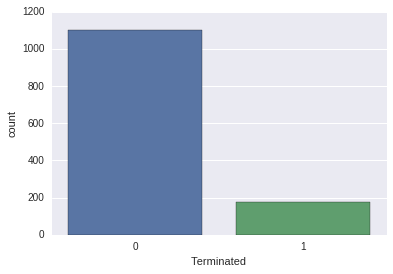

In [83]:
# Employees Left-Stayed Ratio
employees_left_plt = sns.countplot(x = "Terminated",data = attrition_err)

The proportion of Terminated = 0 is certainly much more than in the sample which includes this data also.Can it be that there is a reason for these anomalies to exist.Do they point towards something- might be an error during the data capturing process for these employees.
Now let us find out if the variable TimeLastPos is an important predictor.

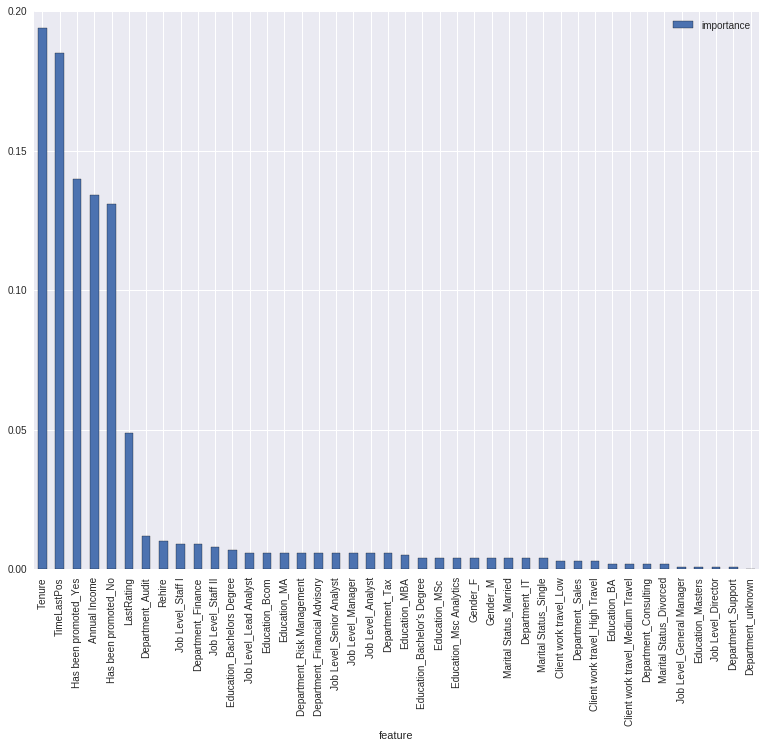

In [84]:
# load X and y
attrition_ohe = pd.get_dummies(attrition_df.drop('Terminated',axis = 1))
predictors = attrition_ohe.columns
X = attrition_ohe[predictors]
y = attrition_df['Terminated']
y = y.ravel()

# Build a forest and compute the feature importances
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

clf = RandomForestClassifier(max_features=5)
clf.fit(X_train.values, y_train)

#show to plot importances
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar(figsize = (13,10))

TimeLastPos is the third most important variable.RandomForests have difficulty in selecting important variables when they are highly correlated.Let's see the correlation plot between Tenure and TimeLastPos.

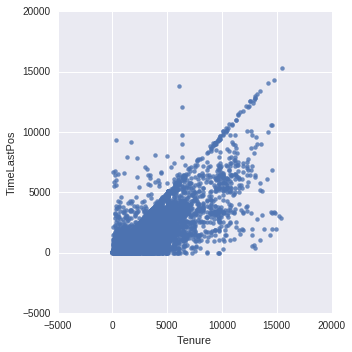

In [85]:
sns.lmplot('Tenure', 'TimeLastPos', data=attrition_df, fit_reg=False)
plt.show()

There is high correlation between the variables as is evident from this figure.Hence we will remove TimeLastPos from the data for modelling purposes.Also,more than number of days since last promotion, a variable like NumberofTimes promoted during Tenure will be more helpful.

Visualization

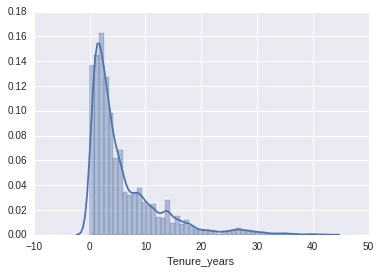

In [86]:
attrition_df['Tenure_years']= round(round((attrition_df['Tenure']/365)*12)/12,1)
attrition_df.drop('Tenure', axis=1, inplace=True)
x = attrition_df['Tenure_years']
sns.distplot(x)

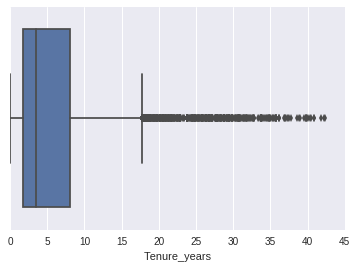

In [87]:
# It seems there are outliers ,so let's verify with a box-plot
sns.boxplot(x)

There are large number of people who have been working in the company for more than 20 years.We will create Tenure Buckets and see the characteristics of these groups.

In [88]:
bins = [0, 3, 5, 10, 15, 20, 43]
group_names = ['0-3', '3-5', '5-10', '10-15','15-20','+20']
tenure_year_bucket = pd.cut(attrition_df['Tenure_years'], bins, labels=group_names)
attrition_df['tenure_year_bucket'] = pd.cut(attrition_df['Tenure_years'], bins, labels=group_names)
attrition_df.tenure_year_bucket.fillna('0-3',inplace = True)
sum(attrition_df.tenure_year_bucket.isnull())

0

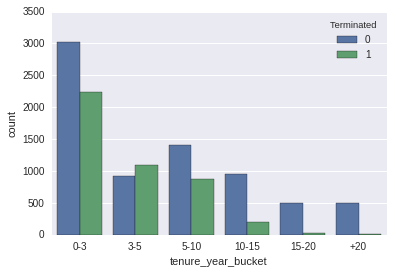

In [89]:
# See the distribution of Terminated across all age buckets
ax = sns.countplot(x="tenure_year_bucket", hue="Terminated", data=attrition_df)

This clearly shows that there are large number of people in the Tenure Bucket of 0-3 and 3-5 years who have left.
What might be the reason? Let's see the number of promotions in these buckets.

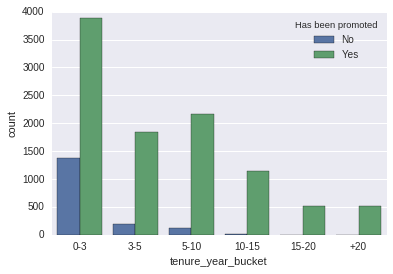

In [90]:
ax = sns.countplot(x="tenure_year_bucket", hue="Has been promoted", data=attrition_df)

There seems to be no evidence suggesting that promotions is a problem,can it be that people are leaving due to Travel issues or Departmental problems.

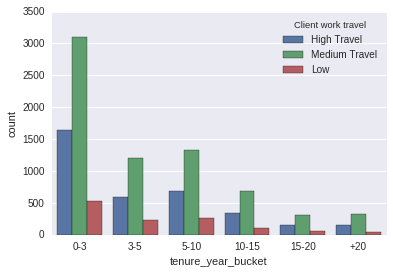

In [91]:
ax = sns.countplot(x="tenure_year_bucket", hue="Client work travel", data=attrition_df)

In the tenure bracket of 0-3 there seems to be quite a lot of travel both but this does not offer any conclusive 
evidence.Is it a problem in the departments?

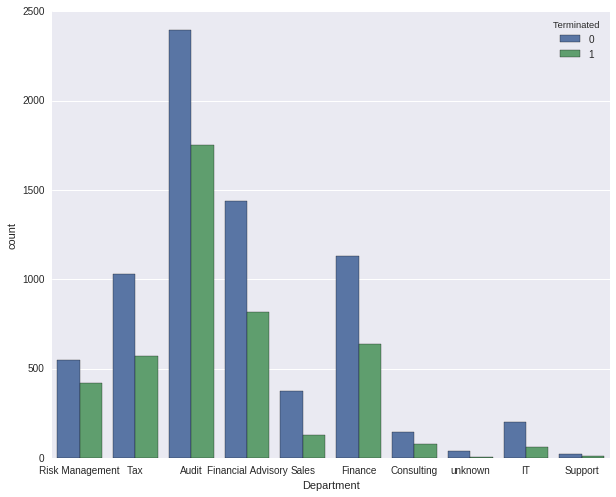

In [92]:
fig, ax = plt.subplots(figsize=(10,8))
sns.countplot(x="Department", hue="Terminated", data=attrition_df)

Audit and Financial Advisory seems to have a large number of people leaving.Let's drill down.

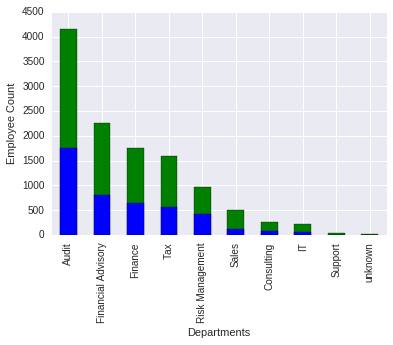

Percentage of employees that left by department 

 Risk Management       43.52
Audit                 42.25
Financial Advisory    36.18
Finance               36.09
Tax                   35.65
Consulting            35.45
Support               29.63
Sales                 24.95
IT                    23.95
unknown                7.32
Name: Department, dtype: float64


In [93]:
left_data = attrition_df[attrition_df.Terminated == 1]
attrition_df.Department.value_counts().plot(kind='bar',color = 'green')
left_data.Department.value_counts().plot(kind='bar', color = 'blue')
plt.title =('Share of Employees that Left by Department')
plt.xlabel('Departments')
plt.ylabel('Employee Count')
plt.show()
percent_left = round(left_data.Department.value_counts()/ attrition_df.Department.value_counts() * 100, 2)
print('Percentage of employees that left by department \n\n', percent_left.sort_values(ascending = False))

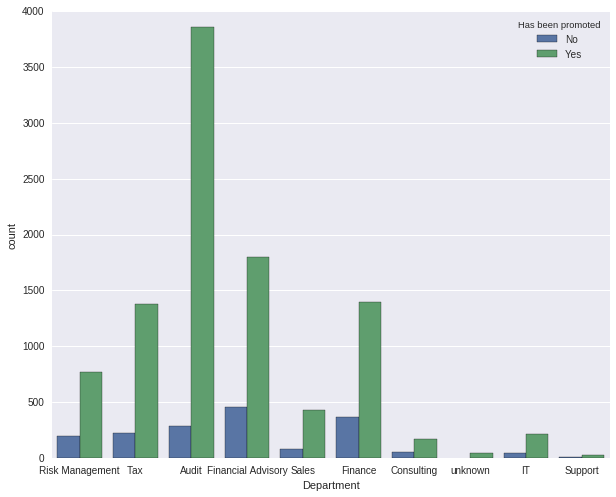

In [94]:
# Let's see the promotions by Dept.
fig, ax = plt.subplots(figsize=(10,8))
sns.countplot(x="Department", hue="Has been promoted", data=attrition_df)

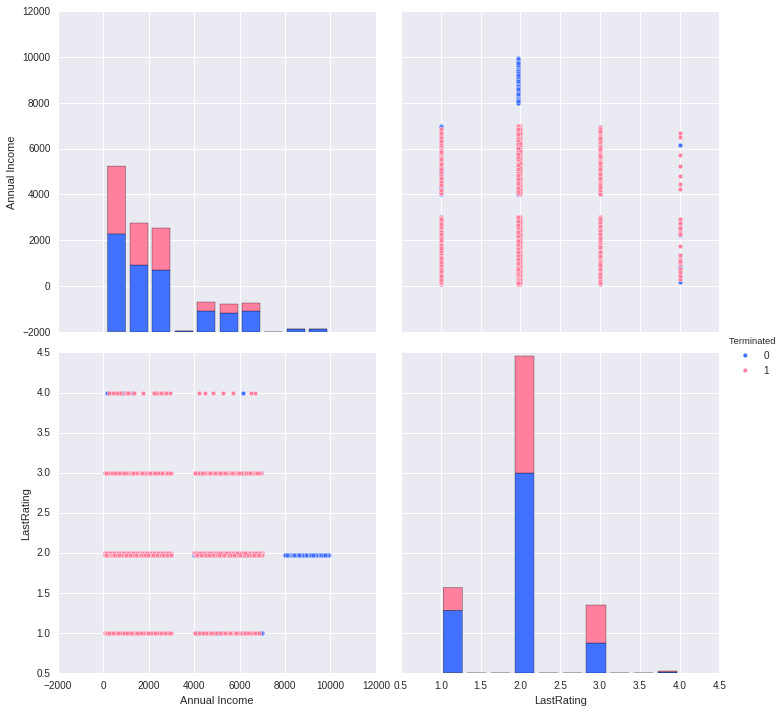

In [95]:
#let's pairplot
plt.figure(figsize=[12,12])
#sns.set(style="ticks")
sns.pairplot(attrition_df, hue='Terminated',size = 5,aspect = 1,palette={0:(0.2588,0.4433,1.0),1:(1.0,0.5,0.62)},
             vars=['Annual Income','LastRating'])
plt.show()

It seems that the Annual Income is a cause for many people leaving.Let us divide the Income into buckets - 'Low',
'Medium' and 'High' and try to re-confirm.

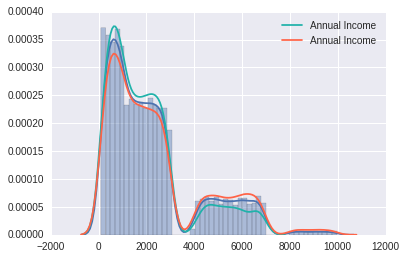

In [96]:
sns.distplot(np.array(attrition_df['Annual Income'].values));
attrition_df['Annual Income'].describe();
sns.kdeplot(attrition_df.loc[attrition_df["Terminated"] == 1, "Annual Income"], color = "lightseagreen")
sns.kdeplot(attrition_df.loc[attrition_df["Terminated"] == 0, "Annual Income"], color = "tomato")

In [97]:
#Divide Annual Income similarly
bins = [0, 1715, 3000,10000]
group_names = ['Low', 'Medium', 'High']
salary_bucket = pd.cut(attrition_df['Annual Income'], bins, labels=group_names)
attrition_df['salary_bucket'] = pd.cut(attrition_df['Annual Income'], bins, labels=group_names)
attrition_df.salary_bucket.value_counts()

Low       5892
Medium    3571
High      2317
Name: salary_bucket, dtype: int64

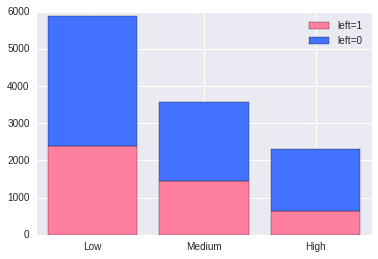

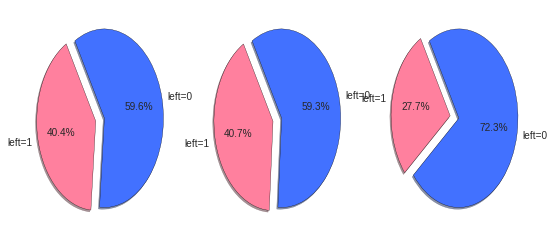

In [98]:
fig = plt.figure()
ax = fig.add_subplot(111)
salary_tick = ['Low','Medium','High']
#number of the the people in each group for both the ones who left and the ones who did not
salary_left = attrition_df[attrition_df['Terminated'] == 1].salary_bucket.value_counts()[0:3]
salary_not_left = attrition_df[attrition_df['Terminated'] == 0].salary_bucket.value_counts()[0:3]

ax.bar(np.arange(len(salary_tick)),salary_left,align='center',color=(1.0,0.5,0.62))
ax.bar(np.arange(len(salary_tick)),salary_not_left,align='center',color=(0.2588,0.4433,1.0),bottom=salary_left)

plt.legend(['left=1','left=0'])
plt.xticks(np.arange(len(salary_tick)), salary_tick)
plt.show()

plt.figure(figsize=[9,4])

for i in range(0,3):
    plt.subplot(1,3,i+1)
    plt.pie([salary_left[i],salary_not_left[i]],
           labels=['left=1','left=0'],
           shadow=True,startangle=120,colors=[(1.0,0.5,0.62),(0.2588,0.4433,1.0)],
           autopct='%1.1f%%',explode=[0.15,0])
    #plt.title(salary_tick[i])

plt.show()

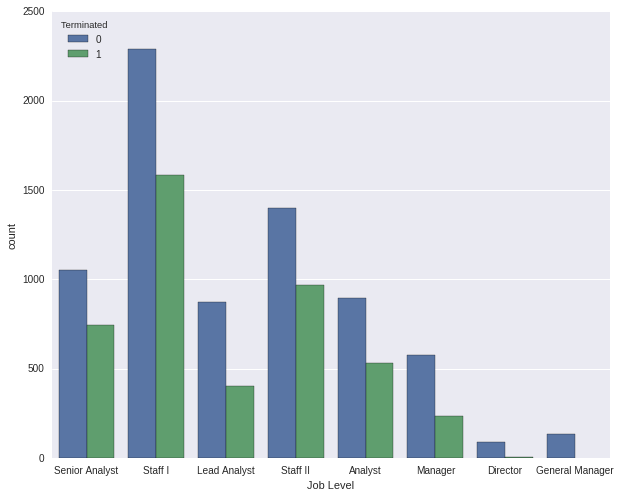

In [99]:
fig, ax = plt.subplots(figsize=(10,8))
sns.countplot(x="Job Level", hue="Terminated", data=attrition_df)

We have seen earlier that salary is a factor which is influencing people staying or leaving.Lets see its breakup 
department wise.

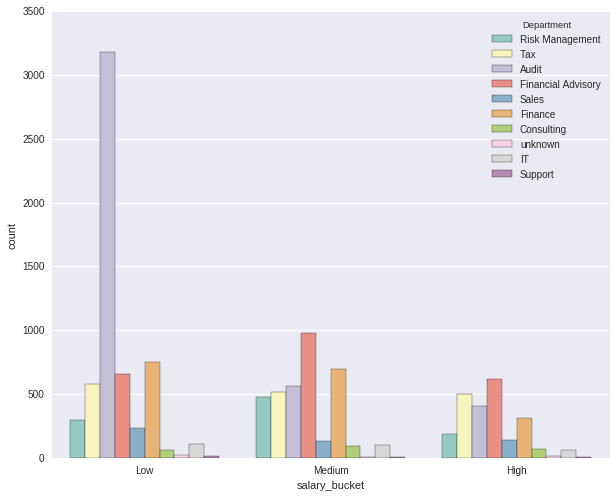

In [100]:
fig, ax = plt.subplots(figsize=(10,8))
sns.countplot(x='salary_bucket', hue='Department', data=attrition_df, palette='Set3')

It seems that low salary and department are influencing Leaving or Staying Decisions.

In [101]:
#Chi-Sq test for Terminated = 0/1 across Department and Salary Bucket.
attrition_df_left = attrition_df[attrition_df['Terminated'] == 1]
contingency = pd.crosstab(attrition_df_left.Department,attrition_df_left.salary_bucket,margins = True)
print (contingency)

salary_bucket        Low  Medium  High   All
Department                                  
Audit               1444     227    82  1753
Consulting            16      44    18    78
Finance              264     282    91   637
Financial Advisory   237     374   203   814
IT                    17      26    20    63
Risk Management      130     232    58   420
Sales                 44      44    37   125
Support                4       3     1     8
Tax                  220     219   131   570
unknown                2       1     0     3
All                 2378    1452   641  4471


In [102]:
eval_mean = attrition_df['LastRating'].mean()
eval_std = np.std(attrition_df['LastRating'])
attrition_df['performance(standard units)'] = (attrition_df['LastRating']- eval_mean)/eval_std

def performance_label(row):
    performance = row['performance(standard units)']
    if performance > 1.96:
        result = 'Above Average'
    else:
        result = 'Average or Below'
    return(result)

attrition_df['performance label'] = attrition_df.apply(performance_label, axis = 1)

left_dict = {1: 'left', 0: 'stayed'}

attrition_df['left(as_string)'] = (attrition_df['Terminated'].map(left_dict))
attrition_df.head()

,Terminated,Rehire,Department,Job Level,TimeLastPos,Has been promoted,LastRating,Client work travel,Education,Gender,Marital Status,Annual Income,Tenure_years,tenure_year_bucket,salary_bucket,performance(standard units),performance label,left(as_string)
0,1,False,Risk Management,Senior Analyst,253,No,1.965571,High Travel,Bachelors Degree,F,Single,1678,0.7,0-3,Low,-3.216697e-10,Average or Below,left
1,1,False,Tax,Senior Analyst,118,Yes,1.000000,Medium Travel,Bachelors Degree,M,Married,2144,3.8,3-5,Medium,-1.652971e+00,Average or Below,left
2,1,False,Audit,Staff I,482,Yes,2.000000,Medium Travel,Msc Analytics,M,Married,584,3.2,3-5,Low,5.893929e-02,Average or Below,left
3,1,False,Financial Advisory,Lead Analyst,1013,No,2.000000,Medium Travel,MA,F,Married,6205,2.8,0-3,High,5.893929e-02,Average or Below,left
4,0,False,Sales,Lead Analyst,1132,Yes,2.000000,Medium Travel,MA,F,Married,6986,3.6,3-5,High,5.893929e-02,Average or Below,stayed


In [103]:
#Next we'll take a look at the average values for numerical columns in our data as an initial look into the potential problem.
columns = (attrition_df.columns)
num_columns = (attrition_df._get_numeric_data().columns)

sep_hr_data = attrition_df
sep_hr_data['Performance cluster'] = sep_hr_data['left(as_string)'] + ' : ' + sep_hr_data['performance label']

sep_hr_pivot = sep_hr_data.pivot_table(index= (['Performance cluster']), values =num_columns, aggfunc=np.mean)
sep_hr_pivot.transpose()

Performance cluster,left : Above Average,left : Average or Below,stayed : Above Average,stayed : Average or Below
Annual Income,2080.121951,1989.073815,1311.500000,2410.692476
LastRating,4.000000,2.079870,4.000000,1.881403
Rehire,0.121951,0.076072,0.166667,0.072359
Tenure_years,4.295122,3.825485,9.141667,7.198780
TimeLastPos,1039.536585,790.369300,1981.833333,1389.556530
performance(standard units),3.482760,0.195670,3.482760,-0.144087


In [104]:
#Now select the attributes from the dataframe to be used in modelling attrition:
attrition_df.columns

Index(['Terminated', 'Rehire', 'Department', 'Job Level', 'TimeLastPos',
       'Has been promoted', 'LastRating', 'Client work travel', 'Education',
       'Gender', 'Marital Status', 'Annual Income', 'Tenure_years',
       'tenure_year_bucket', 'salary_bucket', 'performance(standard units)',
       'performance label', 'left(as_string)', 'Performance cluster'],
      dtype='object')

In [105]:
cols_to_keep = ['Rehire', 'Department', 'Job Level', 'Has been promoted',
                'LastRating', 'Client work travel', 'Education','Gender', 'Marital Status',
                'tenure_year_bucket', 'salary_bucket','Terminated']
attrition_df = attrition_df[cols_to_keep]
attrition_df_copy = attrition_df
attrition_pred = attrition_df_copy[attrition_df_copy.Terminated == 0]
label = attrition_df.pop('Terminated')

In [106]:
cols_categorical = ['Rehire', 'Department', 'Job Level', 'Has been promoted','Client work travel',
                   'Education','Gender', 'Marital Status','tenure_year_bucket', 'salary_bucket']
attrition_df_dummies = pd.get_dummies(attrition_df, columns=cols_categorical)
attrition_df_dummies.isnull().any()
attrition_df.head()
from sklearn.model_selection import train_test_split
data_train, data_test, label_train, label_test = train_test_split(attrition_df_dummies, label,
                                                                     test_size = 0.2,
                                                                     random_state = 42)
label_train = np.array(label_train)
label_test = np.array(label_test)

In [107]:
# Machine learning framework:
from sklearn.pipeline import Pipeline
# Preprocessing
from sklearn.preprocessing import StandardScaler
# Estimators
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.ensemble import RandomForestClassifier
# Evaluation tools
from sklearn.metrics import (
    roc_auc_score, classification_report , accuracy_score , confusion_matrix
)
from sklearn.model_selection import (StratifiedShuffleSplit, cross_val_score,GridSearchCV, RandomizedSearchCV)

def make_pipe(estimator):
    '''Model pipeline'''
    return Pipeline([
        ('scaler', StandardScaler()), ('estimator', estimator)
    ])


def gridsearch(pipe, param_grid, **cv_params):
    '''Grid or randomized search for selecting hyperparameters'''
    n_hyperparams = sum(len(v) for v in param_grid.values())
    if(n_hyperparams < 15):
        gs = GridSearchCV(pipe, param_grid, **cv_params)
    else:
        gs = RandomizedSearchCV(
            pipe, param_grid, **cv_params, n_iter=15
        )
    return gs


class Classifier():
    global metric
    metric = dict(scoring='roc_auc')

    def __init__(self):
        pass

    def assess(self, estimator, X, y, param_grid):
        '''Performance assessments for selecting algorithms
        Using 5x2 nested cross-validation'''
        pipe = make_pipe(estimator)
        # Inner loop: 2-fold CV for hyperparameter selection
        gs = gridsearch(pipe, param_grid, cv=2, **metric)
        # Outer loop: 5-fold CV for model training
        scores = cross_val_score(gs, X, y, cv=5, **metric)
        return (scores.mean(), scores.std())

    def fit(self, estimator, X, y, param_grid):
        '''Train selected model'''
        pipe = make_pipe(estimator)
        gs = gridsearch(pipe, param_grid, cv=5, **metric)
        _ = gs.fit(X, y)
        self.best_pipe_ = gs.best_estimator_
        best_estimator = (
            gs.best_estimator_.named_steps['estimator']
        )
        self.feature_importances_ = (
            best_estimator.feature_importances_
        )
        self.best_params_ = gs.best_params_
        self.score_ = gs.best_score_
        return None

    def predict(self, X):
        '''Make predictions for new data'''
        return self.best_pipe_.predict(X)
    
    def predict_prob(self,X):
        ''' Give probabilities of the event happening'''
        return self.best_pipe_.predict_proba(X)

In [108]:
#Model evaluation

# Hyperparameters common for all models under evaluations
param_common = dict(random_state=42, class_weight='balanced')

# Dataframe for score keeping
model_list = ['Logistic regression', 'Decision tree', 'Random forest']
metric_list = ['auc_mean', 'auc_std', 'runtime (s)']
df_score_eval = pd.DataFrame(columns=model_list, index=metric_list)
#df_score_eval.head()

In [109]:
model_id = model_list[1]

# Modeling
tree = DecisionTreeClassifier(**param_common)
param_grid = {
    'estimator__max_depth': [None] + list(range(1, 11)),
    'estimator__min_samples_leaf': np.arange(1, 10)
}
model = Classifier()
t_start = time.time()
auc_mean, auc_std = model.assess(tree, data_train, label_train, param_grid)
t_elapsed = time.time() - t_start

# Keep score
df_score_eval[model_id] = (auc_mean, auc_std, t_elapsed)
df_score_eval.head()

,Logistic regression,Decision tree,Random forest
auc_mean,NaN,0.864559,NaN
auc_std,NaN,0.004517,NaN
runtime (s),NaN,3.779452,NaN


In [110]:
model_id = model_list[0]
import time
# Modeling : Logistic Regression.
lr = LogisticRegression(**param_common, n_jobs=-1)
param_grid = {
    'estimator__penalty': ['l1', 'l2'],
    'estimator__C': np.logspace(-5, 5, 11),
    'estimator__fit_intercept': [True, False]
}
model = Classifier()   #data_train, data_test, label_train, label_test
t_start = time.time()
auc_mean, auc_std = model.assess(lr, data_train, label_train, param_grid)
t_elapsed = time.time() - t_start

# Keep score
df_score_eval[model_id] = (auc_mean, auc_std, t_elapsed)
df_score_eval.head()

,Logistic regression,Decision tree,Random forest
auc_mean,0.856532,0.864559,NaN
auc_std,0.008931,0.004517,NaN
runtime (s),25.970387,3.779452,NaN


In [111]:
model_id = model_list[2]

# Modeling
forest = RandomForestClassifier(**param_common, n_jobs=-1)
param_grid = {
    'estimator__n_estimators': np.arange(10, 100, 10),
    'estimator__max_depth': [None] + list(range(1, 11)),
    'estimator__min_samples_leaf': np.arange(1, 10)
}
model = Classifier()
t_start = time.time()
auc_mean, auc_std = model.assess(forest, data_train, label_train, param_grid)
t_elapsed = time.time() - t_start

# Keep score
df_score_eval[model_id] = (auc_mean, auc_std, t_elapsed)
df_score_eval.head()

,Logistic regression,Decision tree,Random forest
auc_mean,0.856532,0.864559,0.871852
auc_std,0.008931,0.004517,0.006343
runtime (s),25.970387,3.779452,69.326927


In [112]:
df_score_eval.head()

,Logistic regression,Decision tree,Random forest
auc_mean,0.856532,0.864559,0.871852
auc_std,0.008931,0.004517,0.006343
runtime (s),25.970387,3.779452,69.326927


Train and evaluate the selected model. We focus on Decision Trees as it has AUC comparable to RF and also it's 
AUC_STD is lowest indicating low variance in predictions.

In [113]:
label_list = ['Use all features', 'Use above-mean features']
metric_list = ['auc', 'runtime (s)']
df_score_train = pd.DataFrame(columns=label_list, index=metric_list)
#df_score_train.head()

In [114]:
#Train model:
label = label_list[0]
model = Classifier()
t_start = time.time()
model.fit(forest, data_train, label_train, param_grid)
t_elapsed = time.time() - t_start

# Check selected hyperparameters
print('Selected hyperparameters are:'+
      '\n{param}'.format(param=model.best_params_)
     )

# Keep score
df_score_train[label] = (model.score_, t_elapsed)
df_score_train.head()

# Save and rank feature importances
features = list(data_train.iloc[:, 0:].columns)
ranking_features = pd.Series(model.feature_importances_, index=features)
ranking_features = ranking_features.sort_values(ascending=False)

# Separate important and unimportant features using mean importance
index_num = np.arange(len(ranking_features))
filter_above_mean = ranking_features >= ranking_features.mean()
filter_below_mean = ranking_features < ranking_features.mean()
index_above_mean = index_num[filter_above_mean]
index_below_mean = index_num[filter_below_mean]

Selected hyperparameters are:
{'estimator__min_samples_leaf': 9, 'estimator__max_depth': None, 'estimator__n_estimators': 40}


In [115]:
features_above_mean = ranking_features.index[filter_above_mean]
cols_selected = list(features_above_mean)

data_train = data_train[cols_selected]
data_test = data_test[cols_selected]

label = label_list[1]

# Train model
model = Classifier()
t_start = time.time()
model.fit(forest, data_train, label_train, param_grid)
t_elapsed = time.time() - t_start

# Keep score
df_score_train[label] = (model.score_, t_elapsed)
df_score_train.head()

y_pred = model.predict(data_test)

# Check AUC score:
auc_test = roc_auc_score(y_pred, label_test)
print('AUC of test set = {auc:.4f}'.format(auc=auc_test))

AUC of test set = 0.7559


In [116]:
print (classification_report(label_test, y_pred))
print (accuracy_score(label_test,y_pred))

             precision    recall  f1-score   support

          0       0.83      0.77      0.80      1432
          1       0.68      0.75      0.72       924

avg / total       0.77      0.77      0.77      2356

0.765704584041


In [117]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

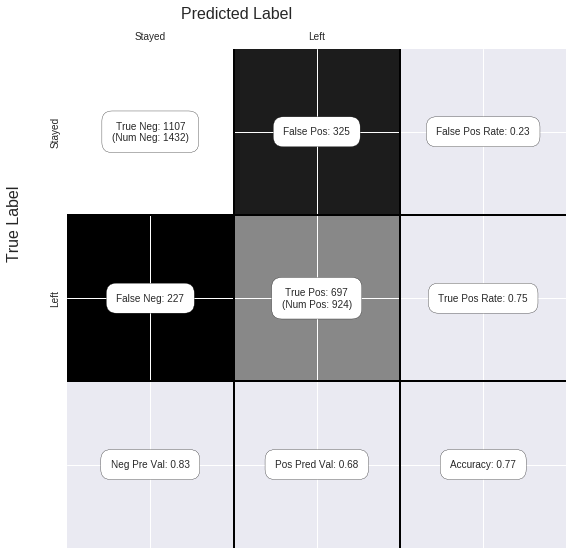

In [118]:
C = confusion_matrix(label_test,y_pred)
show_confusion_matrix(C,['Stayed', 'Left'])

In [119]:
features_above_mean = ranking_features.index[filter_above_mean]
cols_selected = list(features_above_mean)

data_train = data_train[cols_selected]
data_test = data_test[cols_selected]

model_id = model_list[1]
decision_tree = DecisionTreeClassifier(**param_common)
param_grid = {
    'estimator__max_depth': [None] + list(range(1, 11)),
    'estimator__min_samples_leaf': np.arange(1, 10)
}
model = Classifier()

model.fit(decision_tree, data_train, label_train, param_grid)
y_pred = model.predict(data_test)

In [120]:
auc_test = roc_auc_score(y_pred, label_test)
print ('AUC of test set = {auc:.4f}'.format(auc=auc_test))
# Check full classification report
print (classification_report(label_test, y_pred))
print (accuracy_score(label_test,y_pred))

AUC of test set = 0.7564
             precision    recall  f1-score   support

          0       0.83      0.77      0.80      1432
          1       0.68      0.76      0.72       924

avg / total       0.77      0.77      0.77      2356

0.766129032258


In [121]:
# Now lets get the best parameters of the decision tree and build a Decision Tree:
attrition_classifier = DecisionTreeClassifier(max_depth = 10,min_samples_leaf = 7)
attrition_classifier.fit(data_train, label_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=7,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [122]:
# Predict who is at low, medium , high risk of leaving, for this we will take only those records where Terminated = 0
# and assign probabilites to the records.
cols_categorical = ['Rehire', 'Department', 'Job Level', 'Has been promoted','Client work travel',
                  'Education','Gender', 'Marital Status','tenure_year_bucket', 'salary_bucket']
df_dummies = pd.get_dummies(attrition_pred, columns=cols_categorical)
label = attrition_pred.pop('Terminated')
data_pred = df_dummies[cols_selected]
#data_pred.head()

In [123]:
y_pred = attrition_classifier.predict(data_pred)
y_pred_prob = attrition_classifier.predict_proba(data_pred)

In [124]:
y_pred_prob[:,1]
#y_pred_prob.apply(lambda x: ' '.join(x), axis=1)

array([ 0.24390244,  0.81651376,  0.67966574, ...,  0.04051565,
        0.04051565,  0.        ])

In [125]:
#Append these to the records :
data_pred['risk'] = y_pred_prob[:,1]
df_out = pd.merge(data_pred,data_pred[['risk']],how = 'left',left_index = True, right_index = True)
df_out.head()

,Has been promoted_No,Has been promoted_Yes,LastRating,tenure_year_bucket_3-5,tenure_year_bucket_+20,Department_Audit,tenure_year_bucket_15-20,salary_bucket_High,tenure_year_bucket_10-15,tenure_year_bucket_0-3,risk_x,risk_y
4,0.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.243902,0.243902
11,0.0,1.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.816514,0.816514
12,0.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.679666,0.679666
13,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.012195,0.012195
18,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.353612,0.353612


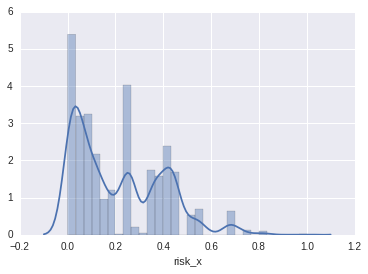

In [126]:
sns.distplot(df_out.risk_x)

In [127]:
#Map risk profile to dataset:
def risk_level(row):
    risk = row['risk_x']
    if risk >= 0.0 and risk < 0.20:
        risk_profile = 'Low'
    elif risk >= 0.20 and risk < 0.40:
        risk_profile = 'Medium'
    elif risk >= 0.40:
        risk_profile = 'High'
    return(risk_profile)

In [128]:
df_out['risk_profile'] = df_out.apply(risk_level, axis = 1)
df_out['Terminated'] = label

In [129]:
df_out.head()

,Has been promoted_No,Has been promoted_Yes,LastRating,tenure_year_bucket_3-5,tenure_year_bucket_+20,Department_Audit,tenure_year_bucket_15-20,salary_bucket_High,tenure_year_bucket_10-15,tenure_year_bucket_0-3,risk_x,risk_y,risk_profile,Terminated
4,0.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.243902,0.243902,Medium,0
11,0.0,1.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.816514,0.816514,High,0
12,0.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.679666,0.679666,High,0
13,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.012195,0.012195,Low,0
18,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.353612,0.353612,Medium,0


In [130]:
data_attr = pd.read_csv(data_folder + 'Attrition_Survival.csv',header = 0)
exp_vars = pd.DataFrame(data_attr['Tenure'])
target = pd.DataFrame(data_attr['Terminated'])
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [131]:
############### Fit Tenure with Terminated
x_train,x_test,y_train,y_test = train_test_split(exp_vars['Tenure'],target['Terminated'],test_size = 0.20,random_state = 100)
kmf_fit = kmf.fit(x_train,event_observed = y_train)
kmf_fit.survival_function_[1:365]

,KM_estimate
timeline,
1.0,0.999894
2.0,0.999788
3.0,0.999682
5.0,0.998940
8.0,0.998834
9.0,0.998728
11.0,0.998622
12.0,0.998198
16.0,0.998092


TypeError: 'str' object is not callable

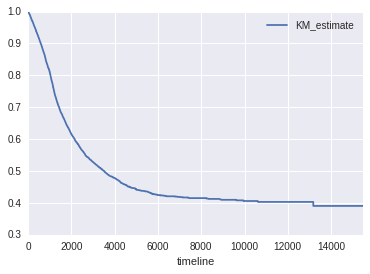

In [132]:
kmf.survival_function_.plot()
from matplotlib import pyplot as plt
import seaborn as sns
plt.title('Survival function of Employees');
%matplotlib inline
kmf.plot()

TypeError: 'str' object is not callable

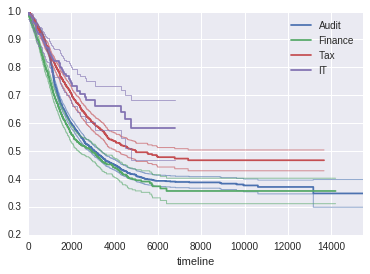

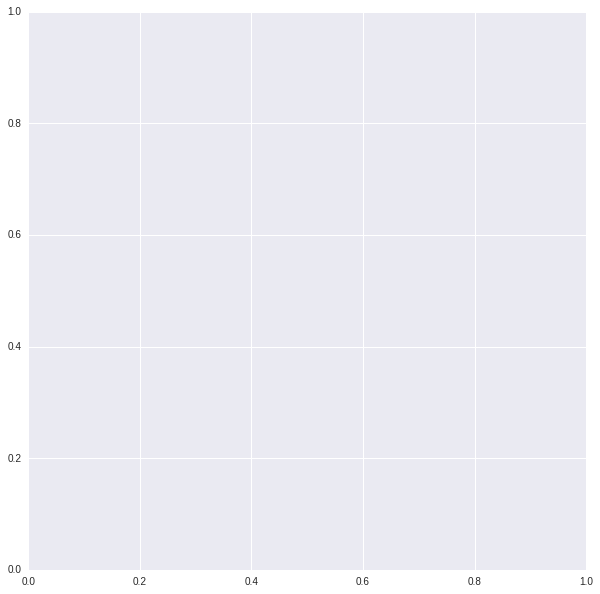

In [140]:
ax = plt.subplot(111)
plt.figure(figsize = [10,10])

Audit = (data_attr["Department"] == "Audit")
kmf.fit(exp_vars[Audit], event_observed=target[Audit], label="Audit")
kmf.plot(ax=ax, ci_force_lines=True)

Finance = (data_attr["Department"] == "Finance")
kmf.fit(exp_vars[Finance], event_observed=target[Finance], label="Finance")
kmf.plot(ax=ax, ci_force_lines=True)

Tax = (data_attr["Department"] == "Tax")
kmf.fit(exp_vars[Tax], event_observed=target[Tax], label="Tax")
kmf.plot(ax=ax, ci_force_lines=True)

IT = (data_attr["Department"] == "IT")
kmf.fit(exp_vars[IT], event_observed=target[IT], label="IT")
kmf.plot(ax=ax, ci_force_lines=True)

plt.ylim(0,1);
plt.title("Lifespans of customers in different states");

In [68]:
Audit = (data_attr.Department == "Audit")

0    False
1    False
2     True
3    False
4    False
Name: Department, dtype: bool